In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# for dirname, _, filenames in os.walk("./"):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import torch
import torch.nn as nn
from scipy import stats
from PIL import Image
import pillow_heif
import filetype

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

Given 30 distinct datasets, each consisting of 26 color images of a lowercase alphabetical letter in cursive handwriting, train a neural network that can read in similar images of cursive handwriting and identify the letter that is written with a moderately high degree of accuracy (ideally ~80s/90s)

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

I downloaded all files from the Google Drive directory, then did some manual inspection with each folder. Based on an initial surface-level analysis, I found that:
- within the S10 directory were 4 directories titled S11, S12, S13, S14.
    - 3 of these 4 nested directories contained the correct amount of lowercase letter images needed
    - S13 contained duplicates for most of the 26 letters
- the S11, S12, S13, and S14 directories not nested inside of the S10 directory were either all incomplete or empty
- there were 2 folders that were duplicates of other existing folders (same images, same names, etc)
- S33 was missing the image for a lowercase j
- S34 was largely incomplete and contained 10 letters
- S35 was completely empty
- many directories either had inconsistent naming (.png for some files and no extension for others), unlabeled data (images were not labeled with the intended letter), and the file extension varied across each directory (.heic, .jpg, .png, etc)

my final decisions for the data batch were to:
- use .png as a universal file extension across all datasets
- rename unlabeled images with their corresponding lowercase letter
    - some datasets were messier than others; hence, some guesswork had to be done for certain directories
- deleted duplicate images in the S13 directory nested within the S10 directory
- use the S11, S12, S13, and S14 directories nested within the S10 directory, and deleted the empty/incomplete directories with the same names outside of S10
- deleted S33, S34, and S35
- renumbered directories so that they would not have gaps

and in the end, our final data consists of:
- 30 distinct directories labeled 1-30 in ./og_data
- 26 color-images of lowercase letters in each directory, labeled (letter).png 

# 3. Explore the Data

Gain insights into the data you have from step 2, making sure to identify any bias

In [16]:
# make sure each directory has 26 images

for n in range(1, 31):
    print(f'\n=======DATASET {n}=======\n')
    path = f"./og_data/{n}"
    filenames = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and 'checkpoint' not in f]
    
    print(f'length of dataset {n}: {len(filenames)}')
    if len(filenames) != 26: 
        print(sorted(filenames))


=======DATASET 1=======

length of dataset 1: 26

=======DATASET 2=======

length of dataset 2: 26

=======DATASET 3=======

length of dataset 3: 26

=======DATASET 4=======

length of dataset 4: 26

=======DATASET 5=======

length of dataset 5: 26

=======DATASET 6=======

length of dataset 6: 26

=======DATASET 7=======

length of dataset 7: 26

=======DATASET 8=======

length of dataset 8: 26

=======DATASET 9=======

length of dataset 9: 26

=======DATASET 10=======

length of dataset 10: 26

=======DATASET 11=======

length of dataset 11: 26

=======DATASET 12=======

length of dataset 12: 26

=======DATASET 13=======

length of dataset 13: 26

=======DATASET 14=======

length of dataset 14: 26

=======DATASET 15=======

length of dataset 15: 26

=======DATASET 16=======

length of dataset 16: 26

=======DATASET 17=======

length of dataset 17: 25
['a.png', 'b.png', 'c.png', 'd.png', 'e.png', 'f.png', 'g.png', 'h.png', 'i.png', 'j.png', 'k.png', 'l.png', 'm.png', 'o.png', 'p.png'

i wanted to see what each directory's images would look like, since data cleaning processes like cropping could vary from directory to directory. 

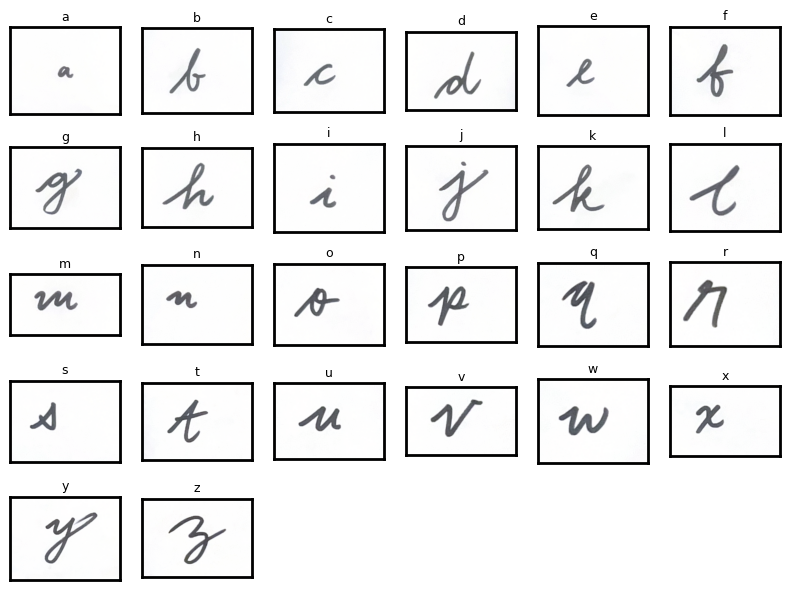

In [34]:
# experimental code that i played around with

alphabet = 'abcdefghijklmnopqrstuvwxyz'  
dir_path = './og_data/29/' 

fig, axes = plt.subplots(5, 6, figsize=(8, 6))
axes = axes.flatten()

for i in range(26):
    img = Image.open(dir_path + alphabet[i] + '.png')
    
    axes[i].imshow(img)
    axes[i].set_title(alphabet[i], fontsize=9, pad=5)

    axes[i].set_aspect('equal')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
    for spine in axes[i].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)

for i in range(26, 30):
    axes[i].axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()

In [ ]:
# now we make that into a function! hopefully this runs

def show_images(dir_num):
    alphabet = 'abcdefghijklmnopqrstuvwxyz'  
    dir_path = f'./og_data/{dir_num}/' 

    fig, axes = plt.subplots(5, 6, figsize=(6, 5))
    axes = axes.flatten()
    
    for i in range(26):
        img = Image.open(dir_path + alphabet[i] + '.png')
        
        axes[i].imshow(img)
        axes[i].set_title(alphabet[i], fontsize=9, pad=5)
    
        axes[i].set_aspect('equal')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        
        for spine in axes[i].spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(2)
    
    for i in range(26, 30):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    plt.show()

since we want to see individual images for each directory, we have to run each manually. 
some of them are encountering errors, like folder 1, due to what i think are file type conversion errors. 
those will be addressed and fixed when it comes time for data preprocessing

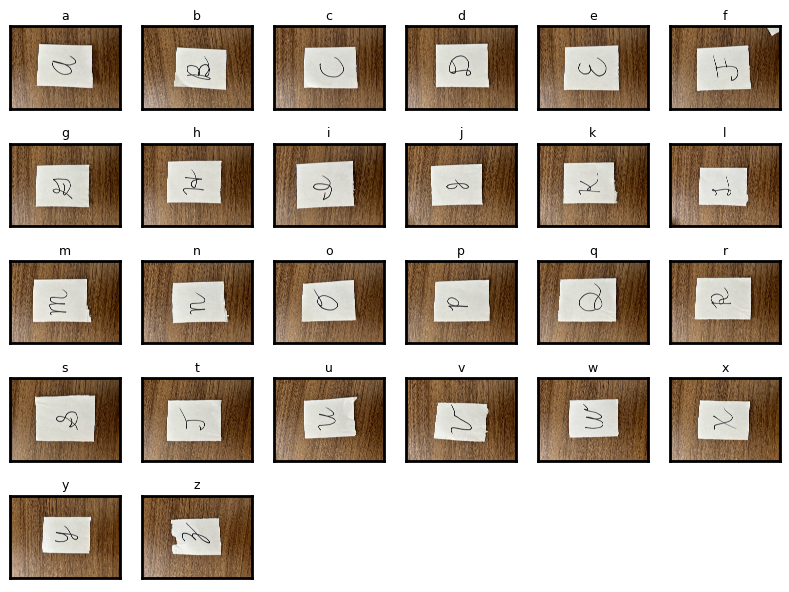

In [56]:
show_images(2)

will require rotations + cropping

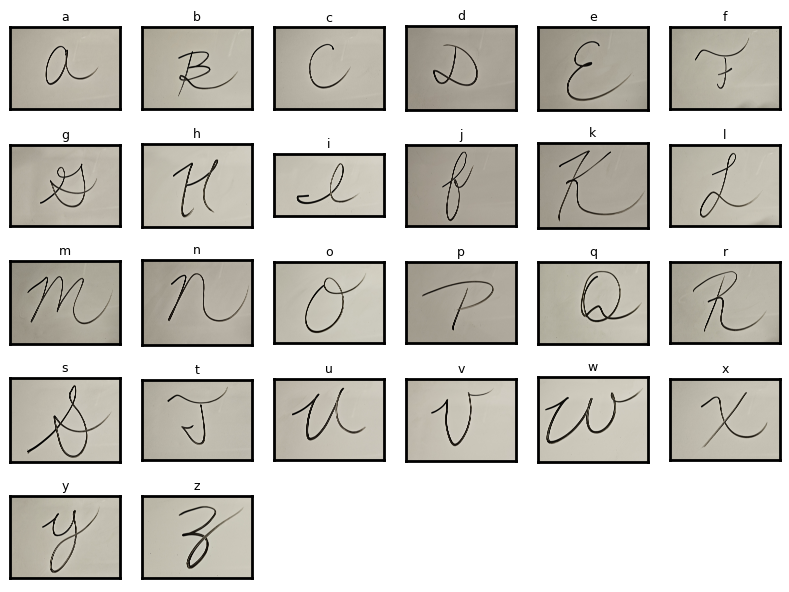

In [58]:
show_images(4)

not too bad! again, i worry that letters may be too zoomed in but this seems universal enough of an issue that it's not an outlier

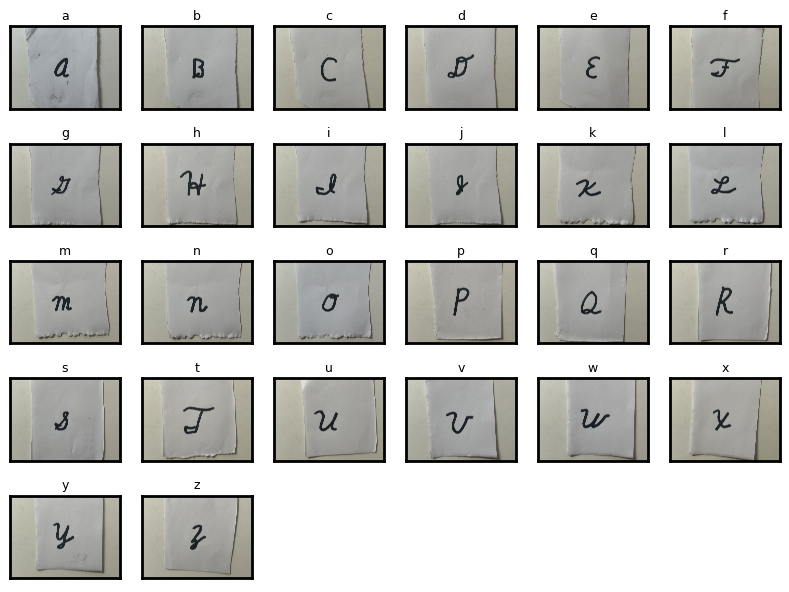

In [61]:
show_images(5)

needs to be centrally cropped later on

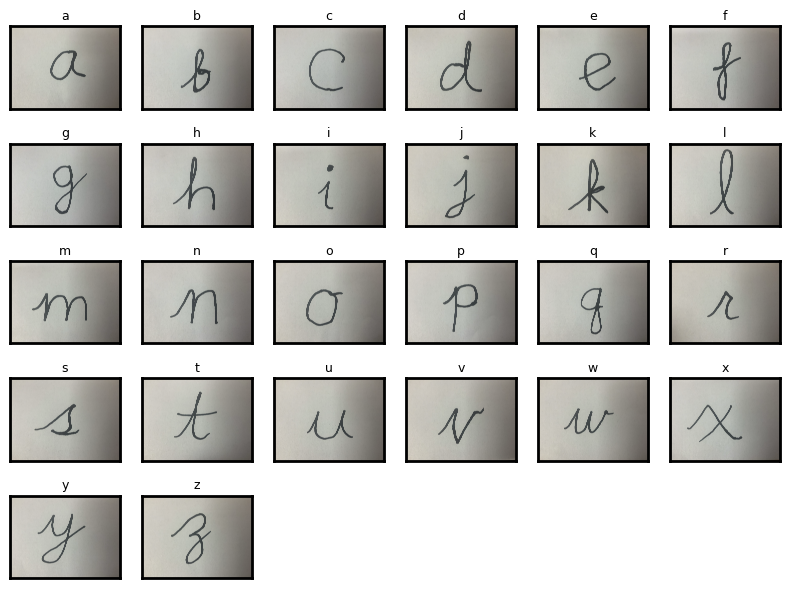

In [60]:
show_images(6)

not bad! shadows can be fixed later on with color standardization (or at least i hope)

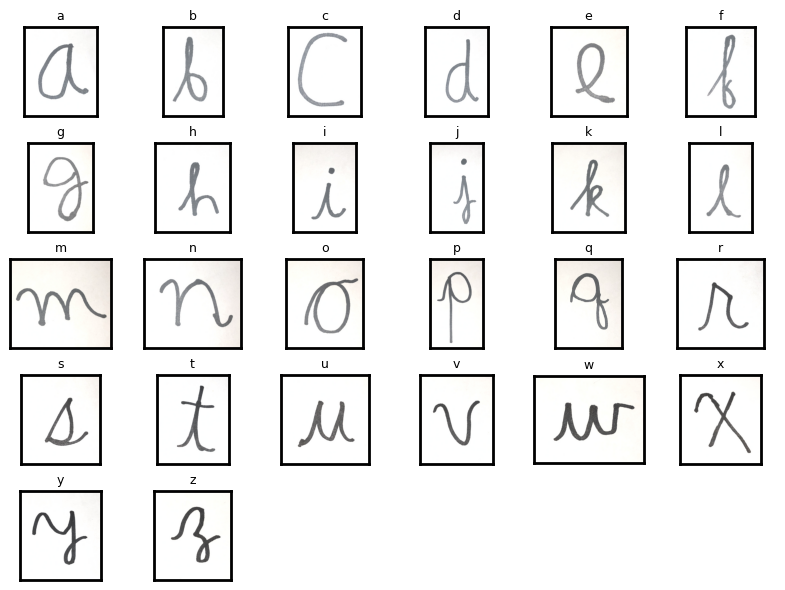

In [55]:
show_images(7)

this one actually isnt bad! besides the standardized processes like central crop + color scaling, this dataset doesnt need much additional processing. my only concern is that these letters are too zoomed in; if i want to standardize all images across all 30 directories to be square-sized, i may need to do some more trickery here

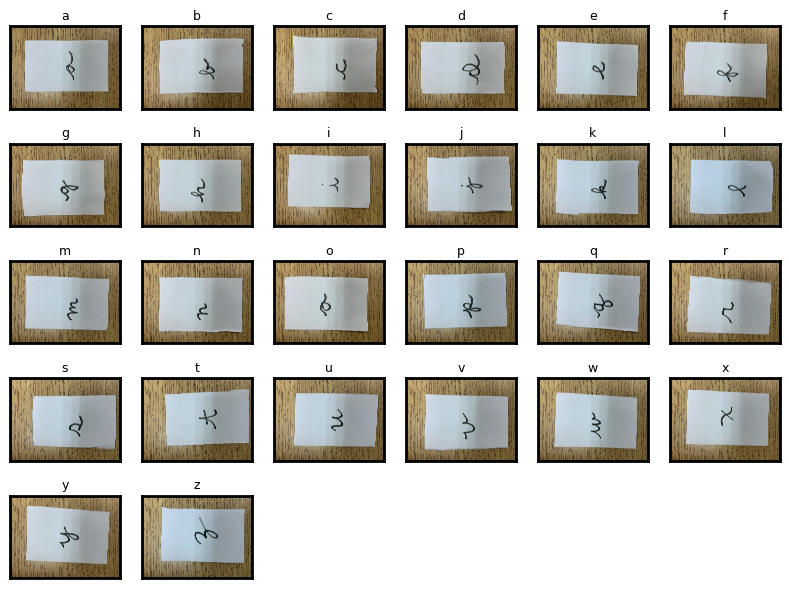

In [64]:
show_images(9)

will require cropping + rotating

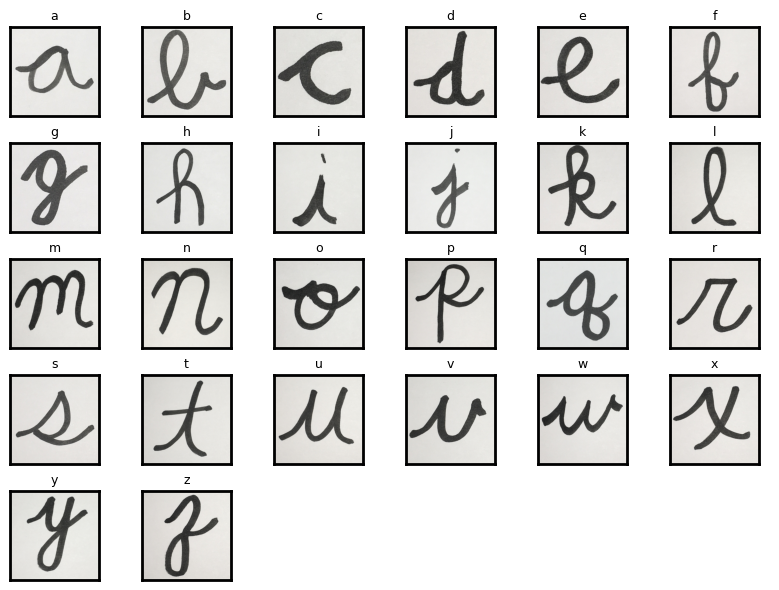

In [65]:
show_images(10)

although i manually converted all files to .png's, i seem to be having some errors regarding reading them due to the wrong file type. lets double check:


In [76]:
# code to check if each directory only contains png 

dir_name = './og_data/'
alphabet = 'abcdefghijklmnopqrstuvwxyz'

filetypes = []
for let in range(len(alphabet)):
    guess = filetype.guess(dir_name + f'1/{alphabet[let]}.png')
    filetypes.append(guess.mime[6:])

print(filetypes)

['heic', 'png', 'png', 'png', 'png', 'png', 'png', 'png', 'png', 'png', 'png', 'png', 'png', 'png', 'png', 'png', 'png', 'png', 'png', 'png', 'png', 'png', 'png', 'png', 'png', 'png']


In [102]:
files_to_convert = {}

for i in range(1, 31):
    print(f'\n=============DATASET {i}=============\n') 
    for let in range(len(alphabet)):
        if (i == 17 and let == 13) or (i == 30 and let == 9):
            print(f'missing ./og_data/{i}/{alphabet[let]}.png')
            continue
        filepath = f'./og_data/{i}/{alphabet[let]}.png'
        guess = filetype.guess(filepath).mime[6:]
        if guess != 'png':
            print(f'NEEDS TO BE CONVERTED: {filepath[-5:]} / TYPE: {guess}')
            files_to_convert[filepath] = guess

print(files_to_convert)


=============DATASET 1=============


=============DATASET 2=============


=============DATASET 3=============


=============DATASET 4=============


=============DATASET 5=============


=============DATASET 6=============


=============DATASET 7=============


=============DATASET 8=============


=============DATASET 9=============


=============DATASET 10=============


=============DATASET 11=============


=============DATASET 12=============

NEEDS TO BE CONVERTED: o.png / TYPE: heic
NEEDS TO BE CONVERTED: p.png / TYPE: heic
NEEDS TO BE CONVERTED: q.png / TYPE: heic
NEEDS TO BE CONVERTED: r.png / TYPE: heic
NEEDS TO BE CONVERTED: s.png / TYPE: heic
NEEDS TO BE CONVERTED: t.png / TYPE: heic
NEEDS TO BE CONVERTED: u.png / TYPE: heic
NEEDS TO BE CONVERTED: v.png / TYPE: heic
NEEDS TO BE CONVERTED: w.png / TYPE: heic
NEEDS TO BE CONVERTED: x.png / TYPE: heic
NEEDS TO BE CONVERTED: y.png / TYPE: heic
NEEDS TO BE CONVERTED: z.png / TYPE: heic

=============DATASET 13=============

# 4. Prepare the Data


Apply any data transformations and explain what and why

In [103]:
# convert all heic and jpeg images to png

pillow_heif.register_heif_opener()

for filepath in files_to_convert:
    img = Image.open(filepath)
    img.save(filepath, format='png')
    print(f'converted {filepath} into png')

converted ./og_data/12/o.png into png
converted ./og_data/12/p.png into png
converted ./og_data/12/q.png into png
converted ./og_data/12/r.png into png
converted ./og_data/12/s.png into png
converted ./og_data/12/t.png into png
converted ./og_data/12/u.png into png
converted ./og_data/12/v.png into png
converted ./og_data/12/w.png into png
converted ./og_data/12/x.png into png
converted ./og_data/12/y.png into png
converted ./og_data/12/z.png into png
converted ./og_data/15/l.png into png
converted ./og_data/20/a.png into png
converted ./og_data/20/b.png into png
converted ./og_data/20/c.png into png
converted ./og_data/20/d.png into png
converted ./og_data/20/e.png into png
converted ./og_data/20/f.png into png
converted ./og_data/20/g.png into png
converted ./og_data/20/h.png into png
converted ./og_data/20/i.png into png
converted ./og_data/20/j.png into png
converted ./og_data/20/k.png into png
converted ./og_data/20/l.png into png
converted ./og_data/20/m.png into png
converted ./

In [104]:
# check all non-png images again

for i in range(1, 31):
    print(f'\n=============DATASET {i}=============\n') 
    for let in range(len(alphabet)):
        if (i == 17 and let == 13) or (i == 30 and let == 9):
            print(f'missing ./og_data/{i}/{alphabet[let]}.png')
            continue
        filepath = f'./og_data/{i}/{alphabet[let]}.png'
        guess = filetype.guess(filepath).mime[6:]
        if guess != 'png':
            print(f'NEEDS TO BE CONVERTED: {filepath[-5:]} / TYPE: {guess}')
            files_to_convert[filepath] = guess



=============DATASET 1=============


=============DATASET 2=============


=============DATASET 3=============


=============DATASET 4=============


=============DATASET 5=============


=============DATASET 6=============


=============DATASET 7=============


=============DATASET 8=============


=============DATASET 9=============


=============DATASET 10=============


=============DATASET 11=============


=============DATASET 12=============


=============DATASET 13=============


=============DATASET 14=============


=============DATASET 15=============


=============DATASET 16=============


=============DATASET 17=============

missing ./og_data/17/n.png

=============DATASET 18=============


=============DATASET 19=============


=============DATASET 20=============


=============DATASET 21=============


=============DATASET 22=============


=============DATASET 23=============


=============DATASET 24=============


=============DATASET 25=============


======

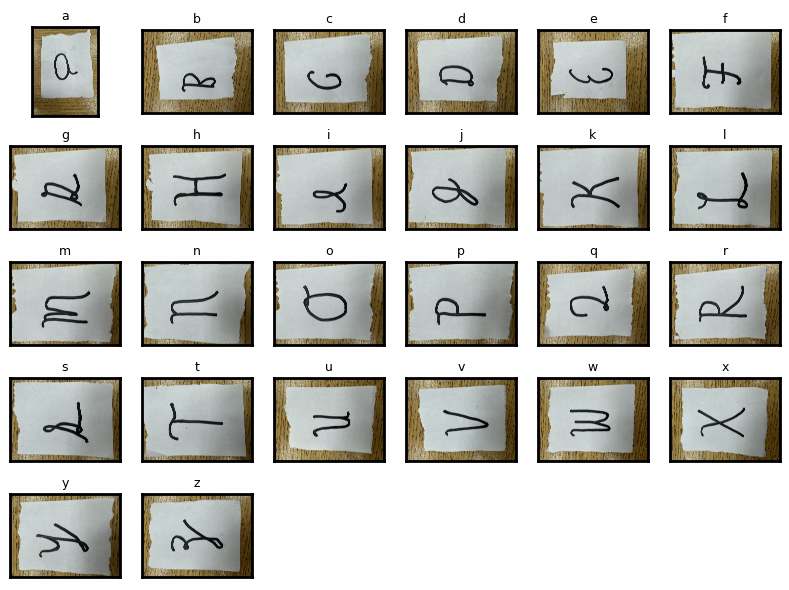

In [106]:
show_images(1)

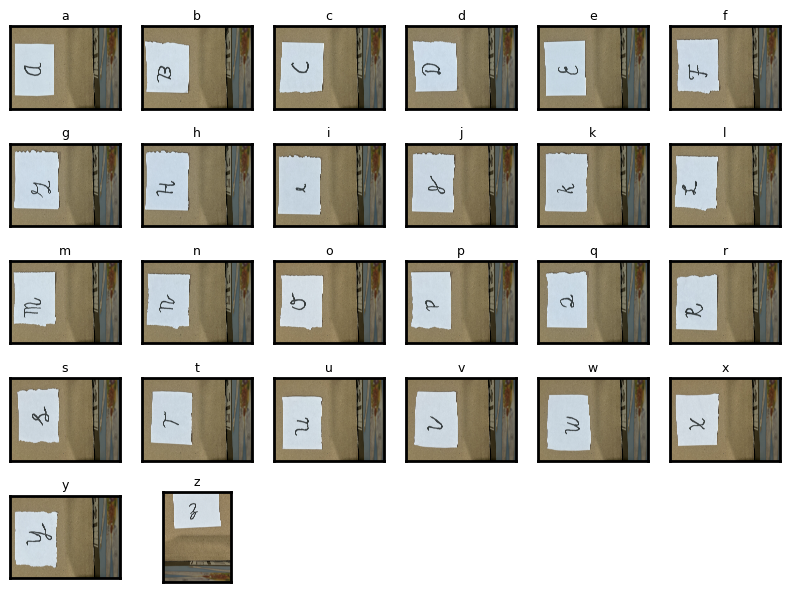

In [108]:
show_images(3)

# 5. Model the data 
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken

# 8. Launch the Model System
Define your production run code, This should be self sufficient and require only your model pramaters 


In [ ]:
def inference():
    